In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy import stats
from scipy.stats import sem
import statistics
import statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as sps
import contextily as ctx 
import folium
import matplotlib.pyplot as plt  # For colormap access
import branca.colormap as cm  # For creating a Folium-compatible color scale


In [2]:
df = pd.read_csv('transaction data.csv')

In [3]:
df.head()

,Transaction Type,Subtype,Sales Sequence,No,Month,Quarter,Year,Date,Community,Property,...,Floor,Parking,Balcony Area,Size (Sqf),Land Size,Amount (AED),AED/Sqf,Finance Value (AED),Developer,bedroom_count
0,Sales - Off-Plan,Sell - Pre registration,Primary,102-66485-2023,12,4,2023,14-Dec-23,Palm Jumeirah,Como Residences,...,72.0,10,6047.22,21949.30,6635.00,500000000.0,22779.77,NaN,THE PALM- JUMEIRAH CO. L.L.C,5.0
1,Sales - Off-Plan,Sell - Pre registration,Primary,102-52395-2023,10,4,2023,5-Oct-23,Palm Jumeirah,Ava At Palm Jumeirah By Omniyat,...,20.0,"B1-15, B1-15A,B1-16 to B1-19, B1-19A, B1-20, ...",13269.97,32160.25,6635.00,220000000.0,6840.74,NaN,Omniyat Properties,5.0
2,Sales - Ready,Sale,Secondary,11-27298-2023,8,3,2023,29-Aug-23,Emirates Hills,Emirates Hills - Sector E,...,16.0,NaN,221.00,14596.53,41704.36,209000000.0,14318.47,NaN,Emaar Properties PJSC,6.0
3,Sales - Off-Plan,Sell - Pre registration,Primary,102-44069-2023,9,3,2023,4-Sep-23,Palm Jumeirah,EOME,...,16.0,NaN,221.00,16186.37,24921.57,202000000.0,12479.64,NaN,Blue Haven Real Estate Development LLC,6.0
4,Sales - Off-Plan,Sell - Pre registration,Primary,102-59794-2023,11,4,2023,9-Nov-23,Palm Jumeirah,EOME,...,16.0,NaN,221.00,16186.37,21824.66,200000000.0,12356.08,NaN,Blue Haven Real Estate Development LLC,6.0


In [4]:
df.columns

Index(['Transaction Type', 'Subtype', 'Sales Sequence', 'No', 'Month',
       'Quarter', 'Year', 'Date', 'Community', 'Property', 'Property Type',
       'Unit', 'Bedrooms', 'Floor', ' Parking ', 'Balcony Area', 'Size (Sqf)',
       'Land Size', 'Amount (AED)', 'AED/Sqf', 'Finance Value (AED)',
       'Developer', 'bedroom_count'],
      dtype='object')

In [5]:
df['Community'].unique()

array(['Palm Jumeirah', 'Emirates Hills', 'Dubai Hills Estate',
       'Tilal Al Ghaf', 'Al Barari', 'Downtown Dubai', 'Jumeirah Islands'],
      dtype=object)

In [6]:
locations = gdf = gpd.read_file('export.geojson')
locations = locations[['name:en', 'geometry']]

locations = locations.rename(columns={'name:en': 'name'})
locations['name'] = locations['name'].replace(to_replace='Dubai Hills', value='Dubai Hills Estate')


In [7]:
locations.head()

,name,geometry
0,Jumeirah Islands,"POLYGON ((55.14387 25.06082, 55.14530 25.05971..."
1,Dubai Hills Estate,"POLYGON ((55.25558 25.08726, 55.25578 25.08977..."
2,Tilal Al Ghaf,"POLYGON ((55.23690 25.02501, 55.23841 25.02581..."
3,Palm Jumeirah,"POLYGON ((55.13485 25.09780, 55.13830 25.09956..."
4,Emirates Hills,"POLYGON ((55.15834 25.07745, 55.15863 25.07708..."


In [8]:
result = gpd.GeoDataFrame(pd.merge(df, locations, left_on='Community', right_on='name', how='left'))

In [9]:
result['Amount (AED)'] = result['Amount (AED)'].astype(int)

In [10]:
median_values = pd.DataFrame(result.groupby('name')['Amount (AED)'].median())

In [11]:
median_values = gpd.GeoDataFrame(pd.merge(median_values, locations, left_on='name', right_on='name', how='left'))

In [12]:
median_values

,name,Amount (AED),geometry
0,Al Barari,6200000.0,"POLYGON ((55.31037 25.09276, 55.31066 25.09343..."
1,Downtown Dubai,2600000.0,"POLYGON ((55.27273 25.20391, 55.27175 25.20441..."
2,Dubai Hills Estate,1914888.0,"POLYGON ((55.25558 25.08726, 55.25578 25.08977..."
3,Emirates Hills,39000000.0,"POLYGON ((55.15834 25.07745, 55.15863 25.07708..."
4,Jumeirah Islands,12800000.0,"POLYGON ((55.14387 25.06082, 55.14530 25.05971..."
5,Palm Jumeirah,4250000.0,"POLYGON ((55.13485 25.09780, 55.13830 25.09956..."
6,Tilal Al Ghaf,4300000.0,"POLYGON ((55.23690 25.02501, 55.23841 25.02581..."


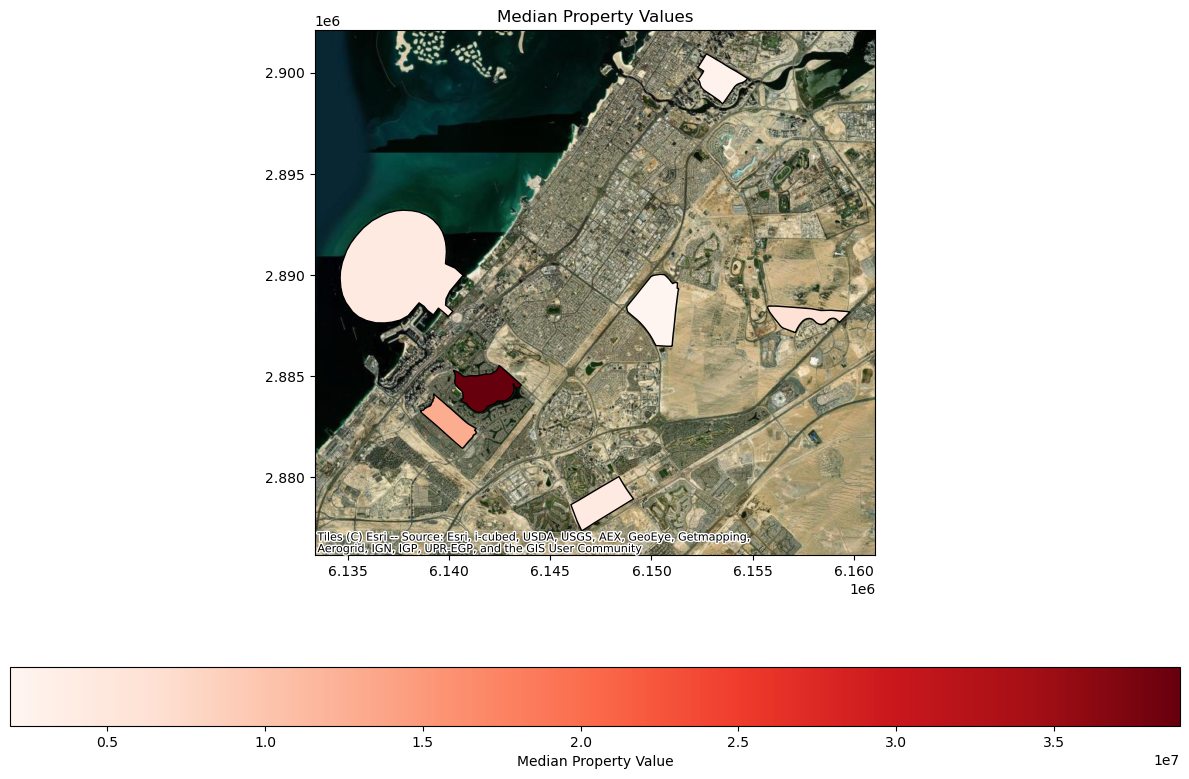

<Figure size 640x480 with 0 Axes>

In [13]:
gdf = median_values
# Ensure the GeoDataFrame is using a projected CRS (e.g., Web Mercator)
gdf = gdf.to_crs(epsg=3857)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the polygons, color-coded by average property value
gdf.plot(column='Amount (AED)', ax=ax, legend=True, 
         legend_kwds={'label': 'Median Property Value', 'orientation': 'horizontal'},
         cmap='Reds')
gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=12)

# Add title and adjust layout
plt.title('Median Property Values')
plt.tight_layout()

# Show the map
plt.show()

# Optionally, save the map
plt.savefig('property_value_map.png', dpi=300, bbox_inches='tight')

In [14]:
df1 = pd.read_csv('coefficients.csv')

In [15]:
df1.head(6)

,Cities,Cis
0,Emirates Hills,0.4415
1,Dubai Hills Estate,0.5503
2,Palm Jumeirah,0.9951
3,Tilal Al Ghaf,0.2223
4,Downtown Dubai,0.8506
5,Jumeirah Islands,0.5690


In [16]:
# Load the GeoJSON file into a GeoDataFrame
locations = gpd.read_file('export.geojson')

# Select and rename columns
locations = locations[['name:en', 'geometry']]
locations = locations.rename(columns={'name:en': 'name'})

# Replace 'Dubai Hills' with 'Dubai Hills Estate' in the 'name' column
locations['name'] = locations['name'].replace(to_replace='Dubai Hills', value='Dubai Hills Estate')

# Perform a left join of cities on locations
result = df1.merge(locations, how='left', left_on='Cities', right_on='name')


In [17]:
result.head(6)

,Cities,Cis,name,geometry
0,Emirates Hills,0.4415,Emirates Hills,"POLYGON ((55.15834 25.07745, 55.15863 25.07708..."
1,Dubai Hills Estate,0.5503,Dubai Hills Estate,"POLYGON ((55.25558 25.08726, 55.25578 25.08977..."
2,Palm Jumeirah,0.9951,Palm Jumeirah,"POLYGON ((55.13485 25.09780, 55.13830 25.09956..."
3,Tilal Al Ghaf,0.2223,Tilal Al Ghaf,"POLYGON ((55.23690 25.02501, 55.23841 25.02581..."
4,Downtown Dubai,0.8506,Downtown Dubai,"POLYGON ((55.27273 25.20391, 55.27175 25.20441..."
5,Jumeirah Islands,0.5690,Jumeirah Islands,"POLYGON ((55.14387 25.06082, 55.14530 25.05971..."


In [18]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt  # For colormap access
import branca.colormap as cm  # For creating a Folium-compatible color scale

# Assuming 'result' is already a GeoDataFrame and has a 'geometry' column with the correct CRS
if not isinstance(result, gpd.GeoDataFrame):
    result = gpd.GeoDataFrame(result, geometry='geometry', crs="EPSG:4326")

# Create a base map centered on Dubai
m = folium.Map(location=[25.2048, 55.2708], zoom_start=10)

# Create a color scale using matplotlib's 'cividis' and convert to branca colormap
min_cis, max_cis = result['Cis'].min(), result['Cis'].max()
cmap = plt.get_cmap('cividis')
color_scale = cm.LinearColormap(
    colors=[cmap(i) for i in range(cmap.N)],
    vmin=min_cis,
    vmax=max_cis,
    caption=' Neighbourhoods Coefficients'  # Caption for the legend
)

# Function to convert matplotlib colormap to hex colors for folium
def style_function(feature):
    return {
        'fillColor': color_scale(feature['properties']['Cis']),
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.6
    }

# Add a GeoJson layer to the map to plot the polygons color-coded by 'Cis'
folium.GeoJson(
    result,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['name', 'Cis'], aliases=['City:', 'CIS:'])
).add_to(m)

# Add the colormap to the map
color_scale.add_to(m)

# Display the map
m.save('polygon_cis_map.html')
m  # If running in a Jupyter environment, you can directly display the map
